In [2]:
from __future__ import unicode_literals, print_function

from copy import deepcopy
import sys

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

sns.set_context("paper", rc={"figure.figsize": (13, 5), "figure.dpi": 300})

## Results of NWE-based Methods

In [3]:
# we are using the Esuli/Sebastiani GI seed set
seeds = ["Turney/Littman (2003)", "Hu/Liu (2004)", "Kim/Hovy (2004)", "Esuli/Sebastiani (2006)",
         "Remus et al. (2010)"]
methods = ["SeedSet", "TNG", "VO", "NC", "$k$-NN", "PCA", "LP"]
n_seeds = len(seeds)
n_methods = len(methods)
_data = {"seeds": seeds * n_methods, "methods": [m for m in methods for _ in xrange(n_seeds)],
         "results":
        # SeedSet
        [0.398, 0.378, 0.434, 0.419, 0.41]
        # Tang
        + [0.414, 0.429, 0.473, 0.353, 0.366]
        # Vo
        + [0.374, 0.378, 0.432, 0.418, 0.391]
        # Nearest Centroids
        + [0.398, 0.378, 0.434, 0.377, 0.41]
        # k-NN
        + [0.468, 0.443, 0.508, 0.425, 0.464]
        # + [0.321, 0.339, 0.434, 0.377, 0.41]
        # PCA
        + [0.398, 0.377, 0.434, 0.368, 0.41]
        # Linear-Projection
        + [0.462, 0.478, 0.513, 0.456, 0.449]
        }
data = pd.DataFrame.from_dict(_data)

In [4]:
data

,methods,results,seeds
0,SeedSet,0.398,Turney/Littman (2003)
1,SeedSet,0.378,Hu/Liu (2004)
2,SeedSet,0.434,Kim/Hovy (2004)
3,SeedSet,0.419,Esuli/Sebastiani (2006)
4,SeedSet,0.410,Remus et al. (2010)
5,TNG,0.414,Turney/Littman (2003)
6,TNG,0.429,Hu/Liu (2004)
7,TNG,0.473,Kim/Hovy (2004)
8,TNG,0.353,Esuli/Sebastiani (2006)
9,TNG,0.366,Remus et al. (2010)


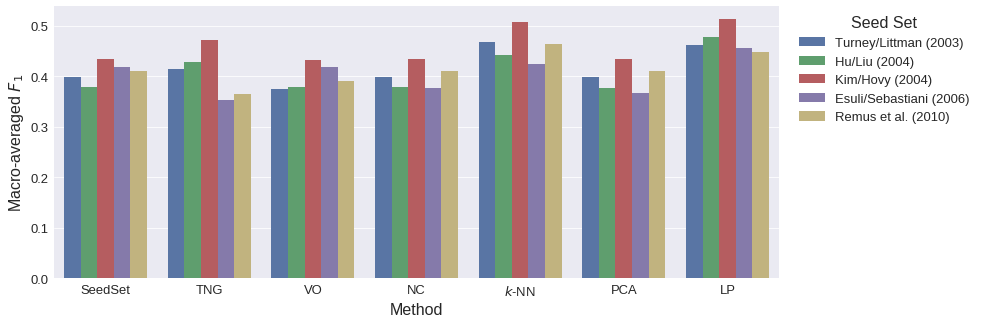

In [5]:
LBL_FS = 16
LGND_FS = 13
sns.set_palette(sns.color_palette("deep", 5) + [sns.xkcd_rgb["macaroni and cheese"], 
                                               sns.xkcd_rgb["bluey grey"]])
sns.set_context(rc={"xtick.labelsize": LGND_FS, "ytick.labelsize": LGND_FS,
                   "legend.fontsize": 20})
ax = sns.barplot(x="methods", y="results", hue="seeds", data=data)
ax.set_xlabel('Method', fontsize=LBL_FS)
ax.set_ylabel('Macro-averaged $F_1$', fontsize=LBL_FS)
leg = ax.legend(loc=(0, 1), bbox_to_anchor=(1.02, 0.55), fontsize=LGND_FS)
leg.set_title("Seed Set", prop = {"size": LBL_FS})
plt.show()

In [6]:
ax.figure.savefig("sentilex-nwe-alt-seed-sets.png", dpi=300, bbox_inches='tight')

## Gradient Computation

In [8]:
import numpy as np

$$\sum_{\vec{p}_+}\sum_{\vec{p}_-}\sum_j\frac{\partial}{\partial \vec{b}_i}
\frac{1}{2}\left(\frac{\vec{b}\cdot(\vec{p}_+ - \vec{p}_-)}{\vec{b}^2}\vec{b}_j\right)^2 = \sum_{\vec{p}_+}\sum_{\vec{p}_-}\sum_j\gamma\vec{b}_j\frac{\partial}{\partial \vec{b}_i}\frac{\vec{b}\cdot(\vec{p}_+ - \vec{p}_-)}{\vec{b}^2}\vec{b}_j$$

$$\sum_{\vec{p}_+}\sum_{\vec{p}_-}\sum_j\gamma\vec{b}_j
\left(\frac{(\vec{p}_+ - \vec{p}_-)_i\vec{b}^2 - 2b_i\gamma}{\vec{b}^4}\vec{b}_j + \gamma\delta(i, j)\right)
=\sum_{\vec{p}_+}\sum_{\vec{p}_-}\sum_j\gamma\vec{b}_j
\left(\left(\Delta_i - 2b_i\gamma\right)\vec{b}_j + \gamma\delta(i, j)\right)$$

$$\sum_{\vec{p}_+}\sum_{\vec{p}_-}
\gamma\left(\left(\Delta_i - 2\vec{b}_i\gamma\right)\sum_j\vec{b}^2_j + \sum_j b_j\gamma\delta(i, j)\right)
=\sum_{\vec{p}_+}\sum_{\vec{p}_-}
\gamma\left(\left(\Delta_i - 2\vec{b}_i\gamma\right)\sum_j\vec{b}^2_j + \gamma\vec{b}_i\right)$$

$$\sum_{\vec{p}_+}\sum_{\vec{p}_-}
\gamma\left(\Delta - 2\gamma\vec{b} + \gamma\vec{b}\right)
=\sum_{\vec{p}_+}\sum_{\vec{p}_-}
\gamma\left(\Delta - \gamma\vec{b}\right)$$

## Projection Line Plot

In [9]:
# find optimal projection line
def _get_vec_len(a_vec):
    """Return length of the vector.

    Args:
      a_vec (np.array): vector whose length should be computed

    Returns:
     (float): vector's length

    """
    return np.sqrt(sum([i**2 for i in a_vec]))


def _compute_eucl_distance(a_vec1, a_vec2):
    """Compute Euclidean distance between two vectors

    Args:
      a_vec1 (np.array): first vector
      a_vec2 (np.array): second vector

    Returns:
      (float): squared Euclidean distance between two vectors
 
    """
    return sum((a_vec1 - a_vec2)**2)


def compute_distance(a_vecs1, a_vecs2):
    """Compute Euclidean distance between all pairs of vectors

    Compute $\sum_{p^{+} \in P^{+}}\sum_{p^{-} \in P^{-}}||p^{+} - p^{-}||^{2}$

    Args:
      a_vecs1 (list[np.array]): positive vectors
      a_vecs2 (list[np.array]): negative vectors

    Returns:
        (float): squared Euclidean distance between all pairs of vectors

    """
    return sum([_compute_eucl_distance(ivec1, ivec2) for ivec1 in a_vecs1
                for ivec2 in a_vecs2])


def _project_vec(a_vec, a_norm, a_prj_line):
    """Project original vector on the projection line.

    Args:
      a_vec (np.array): vector whoch should e projected
      a_norm (float): square length of projection line
      a_prj_line (np.array): projection line

    Returns:
      (np.array): a_vec's projection on `a_prj_line`

    """
    return (np.dot(a_vec, a_prj_line) / a_norm) * a_prj_line


def _project(a_pos_vecs, a_neg_vecs, a_prj_line):
    """Project original vector sets on the projection line

    Args:
      a_pos_vecs (list[np.array]): list of positive vectors
      a_neg_vecs (list[np.array]): list of negative vectors
      a_prj_line (np.array): current projection line

    Returns:
      (2-tuple): lists of projected positive and negative vectors

    """
    idiv = sum(a_prj_line ** 2)
    assert idiv != 0, "Projection vector cannot be zero vector."
    vecs1 = [_project_vec(ivec, idiv, a_prj_line) for ivec in a_pos_vecs]
    vecs2 = [_project_vec(ivec, idiv, a_prj_line) for ivec in a_neg_vecs]
    return (vecs1, vecs2)


def _compute_gradient(a_pos_vecs, a_neg_vecs, a_prj_line):
    """Compute gradient of distance function wrt projection line

    Args:
      a_pos_vecs (list[np.array]): list of positive vectors
      a_neg_vecs (list[np.array]): list of negative vectors
      a_prj_line (np.array): current projection line

    Returns:
      (np.array): gradient vector

    """
    # zero-out the gradient vector
    dot_prod = diff_vec = None
    # prj_squared = a_prj_line ** 2
    idiv = 1.  # np.float128(sum(a_prj_line ** 2))
    idiv_squared = 1.  # idiv ** 2
    # normalized_prj = a_prj_line / idiv
    assert idiv != 0, "Projection vector cannot be zero vector."
    gradient = np.array([0. for _ in a_prj_line])
    for pos_vec in a_pos_vecs:
        for neg_vec in a_neg_vecs:
            diff_vec = pos_vec - neg_vec
            dot_prod = np.dot(a_prj_line, diff_vec)
            # constant 0.5 below is a dirty hack
            gradient += (dot_prod) * (diff_vec - dot_prod * a_prj_line)
    # since we have a quadratic function, the gradient has coefficient
    # two
    return 2 * gradient


def find_optimal_prj(a_pos, a_neg):
    """Find projection line that maximizes the distance between projections.

    Args:
      a_pos: vectors with positive polarity
      a_neg: vectors with negative polarity

    Returns:
      (2-tuple): projection line and cost

    """
    DELTA = 1e-5               # cost difference
    ALPHA = 0.00001             # learning rate
    n = 0                       # current iteration
    max_n = 100000              # maximum number of iterations
    inf = float("inf")
    ipos = ineg = None
    prev_dist = dist = float(inf)
    prj_line = np.array([np.float128(1.) for _ in xrange(2)])
    while (prev_dist == inf or dist - prev_dist > DELTA) and n < max_n:
        prev_dist = dist
        # normalize length of the projection line
        prj_line /= _get_vec_len(prj_line)
        ppos, pneg = _project(a_pos, a_neg, prj_line)
        # compute the distance between positive and negative vectors
        dist = compute_distance(ppos, pneg)
        # update polarity line
        prj_line += ALPHA * _compute_gradient(a_pos, a_neg, prj_line)
        n += 1
    if dist - prev_dist < DELTA:
        print("Model converged: delta = {}".format(dist - prev_dist), file = sys.stderr)
    return (prj_line / np.linalg.norm(prj_line), dist)

In [10]:
# randomly define coordinates of the seed terms
x_pos = np.random.normal(2, 1., 20)
y_pos = np.random.normal(1, 1.5, 20)

x_neg = np.random.normal(-2, 0.7, 20)
y_neg = np.random.normal(-1, 1.7, 20)

x_neut = np.random.normal(-0.5, 1.5, 20)
y_neut = np.random.normal(3., 1.5, 20)

In [11]:
# normalize vectors
pos = [np.array([x, y]) for x, y in zip(x_pos, y_pos)]
neg = [np.array([x, y]) for x, y in zip(x_neg, y_neg)]
neut = [np.array([x, y]) for x, y in zip(x_neut, y_neut)]
subj = pos + neut

In [12]:
np.std(np.array(subj + neut), axis=0)

array([ 1.73035313,  1.82946618])

In [13]:
def len_norm(v):
    return v / np.linalg.norm(v)

def mean_norm(v, mean, std):
    ret = (v - mean) / std
    return ret

pos_len_normed = [len_norm(v) for v in pos]
neg_len_normed = [len_norm(v) for v in neg]
neut_len_normed = [len_norm(v) for v in neut]

all_vecs = np.array(subj + neut)
mean = np.mean(all_vecs, axis=0)
std = np.std(all_vecs, axis=0)
pos_mean_normed = [mean_norm(v, mean, std) for v in pos]
neg_mean_normed = [mean_norm(v, mean, std) for v in neg]
neut_mean_normed = [mean_norm(v, mean, std) for v in neut]

all_vecs_len_normed = np.array([len_norm(v) for v in all_vecs])
mean_len_normed = np.mean(all_vecs_len_normed, axis=0)
std_len_normed = np.std(all_vecs_len_normed, axis=0)
pos_len_mean_normed = [mean_norm(v, mean_len_normed, std_len_normed) for v in pos_len_normed]
neg_len_mean_normed = [mean_norm(v, mean_len_normed, std_len_normed) for v in neg_len_normed]
neut_len_mean_normed = [mean_norm(v, mean_len_normed, std_len_normed) for v in neut_len_normed]

In [14]:
polarity = ["positive"] * len(x_pos) + ["negative"] * len(x_neg) + ["neutral"] * len(x_neut)

x = np.concatenate([[p[0] for p in pos], [n[0] for n in neg], [n[0] for n in neut]])
y = np.concatenate([[p[1] for p in pos], [n[1] for n in neg], [n[1] for n in neut]])

x_len_normed = np.concatenate([[p[0] for p in pos_len_normed],
                             [n[0] for n in neg_len_normed],
                             [n[0] for n in neut_len_normed]])
y_len_normed = np.concatenate([[p[1] for p in pos_len_normed], 
                             [n[1] for n in neg_len_normed], 
                             [n[1] for n in neut_len_normed]])

x_mean_normed = np.concatenate([[p[0] for p in pos_mean_normed],
                             [n[0] for n in neg_mean_normed],
                             [n[0] for n in neut_mean_normed]])
y_mean_normed = np.concatenate([[p[1] for p in pos_mean_normed], 
                             [n[1] for n in neg_mean_normed], 
                             [n[1] for n in neut_mean_normed]])

x_len_mean_normed = np.concatenate([[p[0] for p in pos_len_mean_normed],
                             [n[0] for n in neg_len_mean_normed],
                             [n[0] for n in neut_len_mean_normed]])
y_len_mean_normed = np.concatenate([[p[1] for p in pos_len_mean_normed], 
                             [n[1] for n in neg_len_mean_normed], 
                             [n[1] for n in neut_len_mean_normed]])

data = pd.DataFrame.from_dict({"polarity": polarity, 'x': x, 'y': y})
data_len_normed = pd.DataFrame.from_dict({"polarity": polarity, 
                                          'x': x_len_normed, 'y': y_len_normed})
data_mean_normed = pd.DataFrame.from_dict({"polarity": polarity, 
                                           'x': x_mean_normed, 'y': y_mean_normed})
data_len_mean_normed = pd.DataFrame.from_dict({"polarity": polarity, 
                                           'x': x_len_mean_normed, 'y': y_len_mean_normed})

Model converged: delta = 7.26484781222e-06


-0.452960706345
-74.9197963402
-0.452960706345
-74.9197963402
-4.05296070634
-2.84530776042
-4.05296070634
-2.84530776042


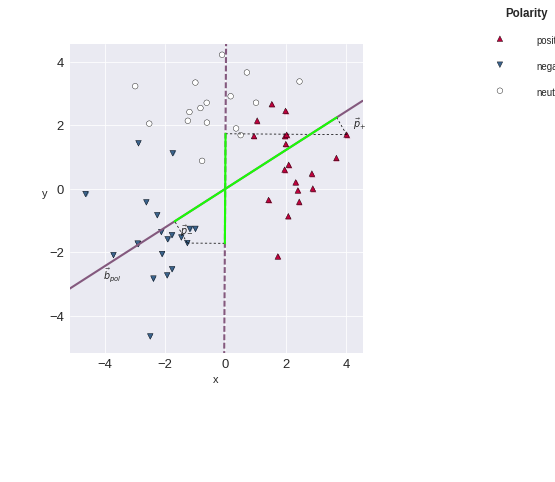

In [15]:
NEG_COLOR = sns.mpl.colors.rgb2hex(sns.xkcd_rgb["denim"])
POS_COLOR = sns.mpl.colors.rgb2hex(sns.xkcd_rgb["rose red"])
NEUT_COLOR = "white"
EDGE_COLORS = ["black"] * len(x_pos) + [POS_COLOR] * len(x_neg) + [NEG_COLOR] * len(x_neut)

DIST_COLOR = sns.mpl.colors.rgb2hex(sns.xkcd_rgb["highlighter green"])
LINE_COLOR = sns.mpl.colors.rgb2hex(sns.xkcd_rgb["dull purple"])
PALETTE = {"positive": POS_COLOR, "negative": NEG_COLOR, "neutral": NEUT_COLOR}
# relative slope of the original line
DEGREE = 45

sns.set_style("darkgrid")

# draw seeds
img = sns.lmplot('x', 'y', data, hue='polarity', 
               palette=PALETTE, fit_reg=False, legend=False,
               markers=['^', 'v', 'o'])
img.map(plt.scatter, 'x', 'y', edgecolor=EDGE_COLORS, linewidth=0.4)

# scatter_kws={"markeredgecolor": 'b'}

img.set_xlabels("x", size=11)
img.set_ylabels("y", size=11, rotation=0)
img.add_legend(title="Polarity")

# tweak the legend
fprop = mpl.font_manager.FontProperties()
fprop.set_weight("semibold")
fprop.set_size("large")
img._legend._legend_title_box._text.set_font_properties(fprop)
img._legend._set_loc((0.85, 0.78))
img._legend.texts[0].set_size("medium")

# draw lines
def draw_line(ax, line, pos, neg, wcoeff=1.5, color="dusty purple", 
              label=None, label_idx=1, label_offset=(0, 0), **kwargs):
    """Draw a line and project on it two points.
    
    Args:
      ax (plt.gca): plot to draw the line on 
      line (np.array): line to plot
      pos (np.array): coordinates of a point with positive polarity 
      line (np.array): coordinates of a point with negative polarity
      wcoeff (float): relative line width
      color (str): XKCD color name
      label (str or None): label to be assigned to the line
      label_idx (int): index of the point to which we should assign the label
      label_offset (tuple): offset of the label text
      kwargs (dict): additional line parameters
    
    Returns:
      (void):
    
    """
    # set line parameters
    lw = mpl.rcParams["lines.linewidth"] * wcoeff
    # remember original plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # estimate line's y-value at 1
    assert line[0], "X value of the projection line should not be zero."
    y = line[1] / line[0]
    # estimate range for the leading dimension of the line
    # draw line
    x_coords = np.linspace(*xlim)
    y_coords = np.linspace(*xlim) * y
    ax.plot(x_coords, y_coords, lw=lw, color=color, **kwargs)
    if label is not None:
        _x = x_coords[label_idx]+ label_offset[0]
        _y = y_coords[label_idx]+ label_offset[1]
        print(_x)
        print(_y)
        label_x = _x
        print(label_x)
        label_y = _y
        print(label_y)
        ax.annotate(label, xy=(_x, _y), xytext=(label_x, label_y))
    # obtain projections of both points
    def project(p, vec):
        return (np.dot(p, vec) / (np.linalg.norm(vec))) * vec

    # plot the projection of the positive point
    pos_prjct = project(pos, line)
    ax.plot(np.linspace(pos[0], pos_prjct[0]),
            np.linspace(pos[1], pos_prjct[1]),
            lw=lw * 0.35, color='k', ls="dotted")
    # plot the projection of the negative point  
    neg_prjct = project(neg, line)
    ax.plot(np.linspace(neg[0], neg_prjct[0]),
            np.linspace(neg[1], neg_prjct[1]),
            lw=lw * 0.35, color='k', ls="dotted")
    # plot the distance between the projections of the two points (positive and negative)
    ax.plot(np.linspace(pos_prjct[0], neg_prjct[0]),
            np.linspace(pos_prjct[1], neg_prjct[1]),
            lw=lw, color=DIST_COLOR)

    # remember original limits
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

# obtain two sample points with opposite polarities
p1 = np.array([data.iloc[6].x, data.iloc[6].y])
p2 = np.array([data.iloc[36].x, data.iloc[36].y])
# compute orthogonal line
prj_line, dist = find_optimal_prj(pos, neg)
M = np.array([[np.cos(DEGREE), -np.sin(DEGREE)],
              [np.sin(DEGREE), np.cos(DEGREE)]])
orth_line = M.dot(prj_line)
# obtain the plot
ax = plt.gca()
ax.set_ylim(*ax.get_xlim())
p1_lbl = ax.annotate(r"$\vec{p}_{+}$", xy=p1, xytext=(p1 + 0.2))
p1_lbl = ax.annotate(r"$\vec{p}_{-}$", xy=p2, xytext=(p2 + np.array([-0.25, 0.25])))
draw_line(ax, orth_line, p1, p2, color=LINE_COLOR, 
          label=r"$\vec{b}^0_{pol}$", label_idx=24, label_offset=(-.05, -10.5), ls="dashed")
draw_line(ax, prj_line, p1, p2,
         label=r"$\vec{b}_{pol}$", label_idx=24, label_offset=(-3.65, -2.6), color=LINE_COLOR)

In [16]:
img.savefig("sentilex.png", dpi=300, bbox_inches='tight')

### Polarity Line of Length-Normalized Vectors

Model converged: delta = 9.80918267057e-06


0.0203512292152
-3.81077289012
0.0203512292152
-3.81077289012
-1.07264877078
-0.457376063936
-1.07264877078
-0.457376063936


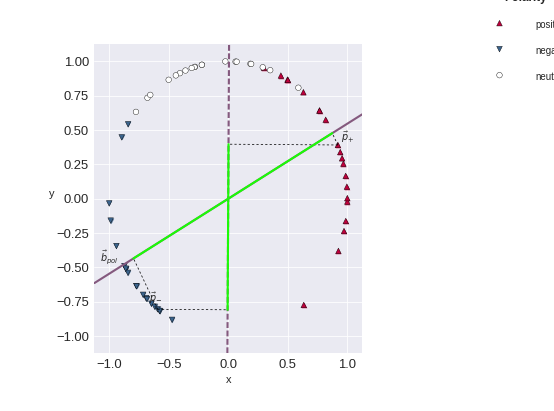

In [17]:
# draw seeds
img_len_normed = sns.lmplot('x', 'y', data_len_normed, hue='polarity', 
               palette=PALETTE, fit_reg=False, legend=False,
               markers=['^', 'v', 'o'])
img_len_normed.map(plt.scatter, 'x', 'y', edgecolor=EDGE_COLORS, linewidth=0.4)

# scatter_kws={"markeredgecolor": 'b'}

img_len_normed.set_xlabels("x", size=11)
img_len_normed.set_ylabels("y", size=11, rotation=0)
img_len_normed.add_legend(title="Polarity")

# tweak the legend
img_len_normed._legend._legend_title_box._text.set_font_properties(fprop)
img_len_normed._legend._set_loc((0.85, 0.78))
img_len_normed._legend.texts[0].set_size("medium")
# compute optimal projection line
prj_line, dist = find_optimal_prj(pos_len_normed, neg_len_normed)
p1_len_normed = np.array([data_len_normed.iloc[6].x, data_len_normed.iloc[6].y])
p2_len_normed = np.array([data_len_normed.iloc[36].x, data_len_normed.iloc[36].y])

ax = plt.gca()
ax.set_ylim(*ax.get_xlim())
p1_lbl = ax.annotate(r"$\vec{p}_{+}$", xy=p1_len_normed, xytext=(p1_len_normed + 0.03))
p1_lbl = ax.annotate(r"$\vec{p}_{-}$", xy=p2_len_normed, xytext=(p2_len_normed + np.array([-0.075, 0.05])))
draw_line(ax, orth_line, p1_len_normed, p2_len_normed, color=LINE_COLOR, 
          label=r"$\vec{b}^0_{pol}$", label_idx=24, label_offset=(.043, -0.19), ls="dashed")
draw_line(ax, prj_line, p1_len_normed, p2_len_normed,
          label=r"$\vec{b}_{pol}$", label_idx=24, label_offset=(-1.05, -0.445), color=LINE_COLOR)

In [18]:
img_len_normed.savefig("sentilex_polarity_len_normed.png", dpi=256, bbox_inches='tight')

### Polarity Line of Mean-Normalized Vectors

Model converged: delta = 9.8798099406e-06


-0.361203927968
-69.9862708328
-0.361203927968
-69.9862708328
-2.52120392797
-1.38866794529
-2.52120392797
-1.38866794529


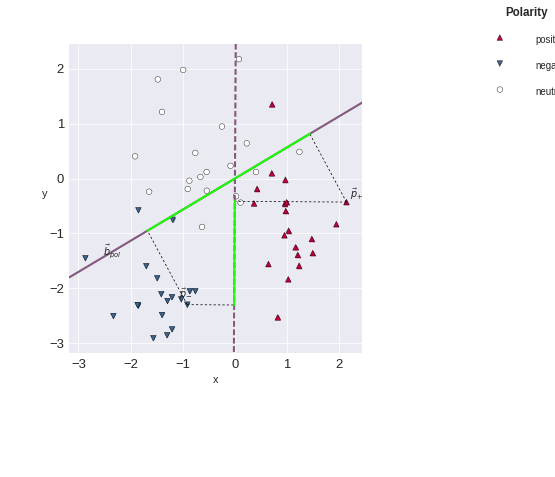

In [19]:
# draw seeds
img_mean_normed = sns.lmplot('x', 'y', data_mean_normed, hue='polarity', 
               palette=PALETTE, fit_reg=False, legend=False,
               markers=['^', 'v', 'o'])
img_mean_normed.map(plt.scatter, 'x', 'y', edgecolor=EDGE_COLORS, linewidth=0.4)

# scatter_kws={"markeredgecolor": 'b'}

img_mean_normed.set_xlabels("x", size=11)
img_mean_normed.set_ylabels("y", size=11, rotation=0)
img_mean_normed.add_legend(title="Polarity")

# tweak the legend
img_mean_normed._legend._legend_title_box._text.set_font_properties(fprop)
img_mean_normed._legend._set_loc((0.85, 0.78))
img_mean_normed._legend.texts[0].set_size("medium")
# compute optimal projection line
prj_line, dist = find_optimal_prj(pos_mean_normed, neg_mean_normed)
p1_mean_normed = np.array([data_mean_normed.iloc[6].x, data_mean_normed.iloc[6].y])
p2_mean_normed = np.array([data_mean_normed.iloc[36].x, data_mean_normed.iloc[36].y])

ax = plt.gca()
ax.set_ylim(*ax.get_xlim())
p1_lbl = ax.annotate(r"$\vec{p}_{+}$", xy=p1_mean_normed, xytext=(p1_mean_normed + 0.07))
p2_lbl = ax.annotate(r"$\vec{p}_{-}$", xy=p2_mean_normed, xytext=(p2_mean_normed + np.array([-0.15, 0.12])))
draw_line(ax, orth_line, p1_mean_normed, p2_mean_normed, color=LINE_COLOR, 
          label=r"$\vec{b}^0_{pol}$", label_idx=24, label_offset=(.06, -2.65), ls="dashed")
draw_line(ax, prj_line, p1_mean_normed, p2_mean_normed,
          label=r"$\vec{b}_{pol}$", label_idx=24, label_offset=(-2.1, -1.15), color=LINE_COLOR)

In [20]:
img_mean_normed.savefig("sentilex_polarity_mean_normed.png", dpi=256, bbox_inches='tight')

### Polarity Line of Mean- and Length-Normalized Vectors

Model converged: delta = 9.6632740072e-06


-0.184528730166
-47.3325124668
-0.184528730166
-47.3325124668
-2.04452873017
-1.19967847609
-2.04452873017
-1.19967847609


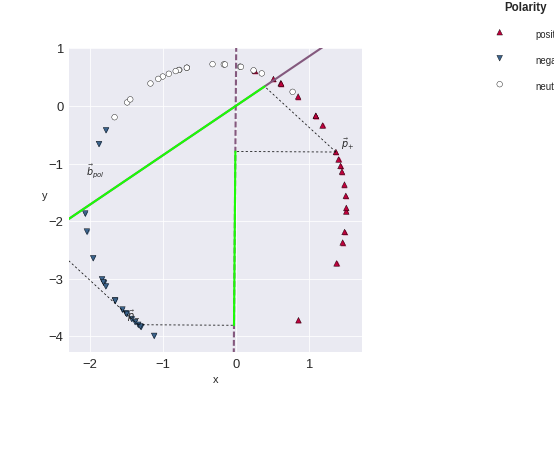

In [21]:
# draw seeds
img_len_mean_normed = sns.lmplot('x', 'y', data_len_mean_normed, hue='polarity', 
               palette=PALETTE, fit_reg=False, legend=False,
               markers=['^', 'v', 'o'])
img_len_mean_normed.map(plt.scatter, 'x', 'y', edgecolor=EDGE_COLORS, linewidth=0.4)

# scatter_kws={"markeredgecolor": 'b'}

img_len_mean_normed.set_xlabels("x", size=11)
img_len_mean_normed.set_ylabels("y", size=11, rotation=0)
img_len_mean_normed.add_legend(title="Polarity")

# tweak the legend
img_len_mean_normed._legend._legend_title_box._text.set_font_properties(fprop)
img_len_mean_normed._legend._set_loc((0.85, 0.78))
img_len_mean_normed._legend.texts[0].set_size("medium")
# compute optimal projection line
prj_line, dist = find_optimal_prj(pos_len_mean_normed, neg_len_mean_normed)
p1_len_mean_normed = np.array([data_len_mean_normed.iloc[6].x, data_len_mean_normed.iloc[6].y])
p2_len_mean_normed = np.array([data_len_mean_normed.iloc[36].x, data_len_mean_normed.iloc[36].y])

ax = plt.gca()
# ax.set_ylim(*ax.get_xlim())
p1_lbl = ax.annotate(r"$\vec{p}_{+}$", xy=p1_len_mean_normed, xytext=(p1_len_mean_normed + 0.075))
p2_lbl = ax.annotate(r"$\vec{p}_{-}$", xy=p2_len_mean_normed, xytext=(p2_len_mean_normed + np.array([-0.15, 0.09])))
draw_line(ax, orth_line, p1_len_mean_normed, p2_len_mean_normed, color=LINE_COLOR, 
          label=r"$\vec{b}^0_{pol}$", label_idx=24, label_offset=(0.13, 2.95), ls="dashed")
draw_line(ax, prj_line, p1_len_mean_normed, p2_len_mean_normed,
          label=r"$\vec{b}_{pol}$", label_idx=24, label_offset=(-1.73, -0.93), color=LINE_COLOR)

In [22]:
img_len_mean_normed.savefig("sentilex_polarity_len_mean_normed.png", dpi=256, bbox_inches='tight')

## Subjective Line

In [23]:
subj_data = data.replace({"polarity": {"positive": "polar", "negative": "polar"}})

Model converged: delta = 9.45569139432e-06


-4.20295129347
-1.27179190903
-4.20295129347
-1.27179190903
2.37871352414
-2.47846710994
2.37871352414
-2.47846710994


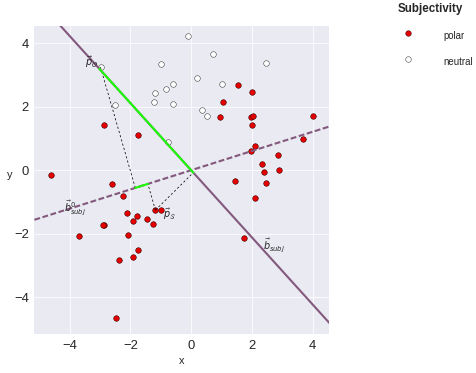

In [24]:
DEGREE_SUBJ = -90

SUBJ_COLOR = sns.mpl.colors.rgb2hex(sns.xkcd_rgb["red"])
SUBJ_PALETTE = (SUBJ_COLOR, NEUT_COLOR)
# draw seeds
img_subj = sns.lmplot('x', 'y', subj_data, hue='polarity', 
               palette=SUBJ_PALETTE, fit_reg=False, legend=False,
               markers='o')
img_subj.map(plt.scatter, 'x', 'y', edgecolor="black", linewidth=0.4)

img_subj.set_xlabels("x", size=11)
img_subj.set_ylabels("y", size=11, rotation=0)
img_subj.add_legend(title="Subjectivity")

# tweak the legend
fprop = mpl.font_manager.FontProperties()
fprop.set_weight("semibold")
fprop.set_size("large")
img_subj._legend._legend_title_box._text.set_font_properties(fprop)
img_subj._legend._set_loc((0.797, 0.8))
img_subj._legend.texts[0].set_size("medium")

# obtain two sample points with opposite polarities
p1 = np.array([subj_data.iloc[33].x, subj_data.iloc[33].y])
p2 = np.array([subj_data.iloc[44].x, subj_data.iloc[44].y])
# compute orthogonal line
prj_line_subj, _ = find_optimal_prj(neut, subj)
M = np.array([[np.cos(DEGREE_SUBJ), -np.sin(DEGREE_SUBJ)],
              [np.sin(DEGREE_SUBJ), np.cos(DEGREE_SUBJ)]])
orth_line_subj = M.dot(prj_line_subj)
# obtain the plot
ax = plt.gca()
ax.set_ylim(*ax.get_xlim())
p1_lbl = ax.annotate(r"$\vec{p}_{\mathcal{S}}$", xy=p1, xytext=(p1 + np.array([0.25, -0.25])))
p2_lbl = ax.annotate(r"$\vec{p}_{\mathcal{O}}$", xy=p2, xytext=(p2 + np.array([-0.5, 0.05])))
draw_line(ax, orth_line_subj, p1, p2, color=LINE_COLOR, 
          label=r"$\vec{b}^0_{subj}$", label_idx=24, label_offset=(-3.8, -1.15), ls="dashed")
draw_line(ax, prj_line_subj, p1, p2,
          label=r"$\vec{b}_{subj}$", label_idx=35, label_offset=(0.6, -0.6), color=LINE_COLOR)

In [25]:
img_subj.savefig("sentilex_subjectivity.png", dpi=256, bbox_inches='tight')

In [26]:
data

,polarity,x,y
0,positive,1.557762,4.963867
1,positive,2.335027,0.206184
2,positive,1.437257,-0.348076
3,positive,0.954960,1.665651
4,positive,1.982406,1.662196
5,positive,2.874252,0.484582
6,positive,4.024685,1.711413
7,positive,1.743069,-2.127121
8,positive,1.544995,2.668635
9,positive,2.038371,1.706737


Model converged: delta = 7.26484781222e-06


0.0270392936551
-66.3197963402
0.0270392936551
-66.3197963402
-4.56464098943
-3.22229210747
-4.56464098943
-3.22229210747


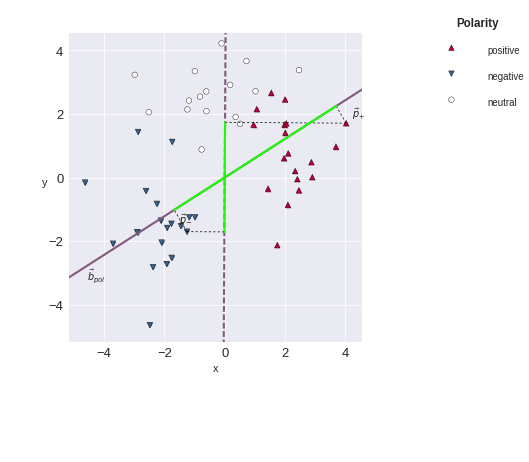

In [27]:
def len_norm(vecs):
    ret = []
    for v in vecs:
        ret.append(v / _get_vec_len(v))
    return ret

# draw seeds
img = sns.lmplot('x', 'y', data, hue='polarity', 
               palette=PALETTE, fit_reg=False, legend=False,
               markers=['^', 'v', 'o'])
img.map(plt.scatter, 'x', 'y', edgecolor=EDGE_COLORS, linewidth=0.4)

img.set_xlabels("x", size=11)
img.set_ylabels("y", size=11, rotation=0)
img.add_legend(title="Polarity")

# tweak the legend
fprop = mpl.font_manager.FontProperties()
fprop.set_weight("semibold")
fprop.set_size("large")
img._legend._legend_title_box._text.set_font_properties(fprop)
img._legend._set_loc((0.8, 0.75))
img._legend.texts[0].set_size("medium")

# obtain two sample points with opposite polarities
p1 = np.array([data.iloc[6].x, data.iloc[6].y])
p2 = np.array([data.iloc[36].x, data.iloc[36].y])
# compute orthogonal line
prj_line, dist = find_optimal_prj(pos, neg)
M = np.array([[np.cos(DEGREE), -np.sin(DEGREE)],
              [np.sin(DEGREE), np.cos(DEGREE)]])
orth_line = M.dot(prj_line)
# obtain the plot
ax = plt.gca()
ax.set_ylim(*ax.get_xlim())
p1_lbl = ax.annotate(r"$\vec{p}_{+}$", xy=p1, xytext=(p1 + 0.2))
p1_lbl = ax.annotate(r"$\vec{p}_{-}$", xy=p2, xytext=(p2 + np.array([-0.25, 0.25])))
draw_line(ax, orth_line, p1, p2, color=LINE_COLOR, 
          label=r"$\vec{b}^0_{pol}$", label_idx=24, label_offset=(.43, -1.9), ls="dashed")
draw_line(ax, prj_line, p1, p2,
          label=r"$\vec{b}_{pol}$", label_offset=(0.4, -0.2), color=LINE_COLOR)

In [28]:
prj_line, dist = find_optimal_prj(pos, neg)
prj_line

Model converged: delta = 7.26484781222e-06


array([ 0.85417282,  0.51998922], dtype=float128)